# Objective
Use osmFISH as a chemistry other than RCA to test whether BlobDetector works as well.

# Results

It made little difference whether 50, 100, or 200 of the expert annotations were used for parameter extraction. Precision and recall with the "best" parameters found remained around 20% and 60% respectively (as shown in the plots at the bottom of this notebook). 

The print statements above the precision vs. recall scatter plots are the number of expert annotations sampled, the various thresholds tested in succession, and the best precision and recall pair found using any of those thresholds.

# Takeaway
Using ground truth to validate is very important, because it can show that a blob detection algorithm that works great for one chemistry might not work very well at all for another chemistry.

In [1]:
import pandas as pd
import numpy as np
import os, warnings, pickle
from instapipeline import QuantiusAnnotation, SpotAnnotationAnalysis, param

from starfish import data, FieldOfView
from starfish.image import Filter
from starfish.spots import DetectSpots
from starfish.types import Axes

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from skimage.io import imread

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

/usr/local/lib/python3.6/site-packages/napari/__init__.py:27: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.12.2. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


In [2]:
num_spots_list = [25, 50, 100, 200]
test_thresholds = [0.0050, 0.0075, 0.0100, 0.0150,0.02, 0.03, 0.04, 0.05]
test_img_filename = 'filtered'

margin = 4
correctness_threshold = 10

In [3]:
if not os.path.exists('./bootstrap_data/'):
    os.mkdir('./bootstrap_data/')

In [4]:
test_img_path = 'single_plane_filtered.png'
im = imread(test_img_path, as_gray=True)
img_height = len(im)
expert_path = 'filtered.csv'
expert_coords = np.asarray(pd.read_csv(expert_path))
num_spots_total = len(expert_coords)

In [5]:
from skimage.feature import blob_log

num_spots_sample = 25
0.23350346336128328 0.5387182910547397


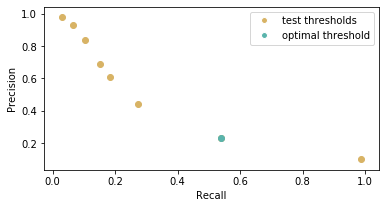

num_blobs = 10972


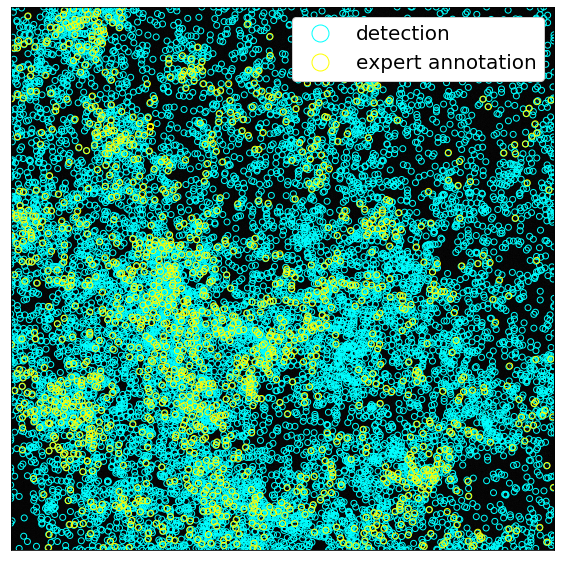

num_spots_sample = 50
0.2277864719179273 0.5574098798397864


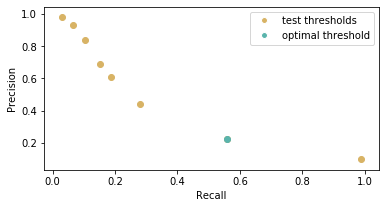

num_blobs = 11502


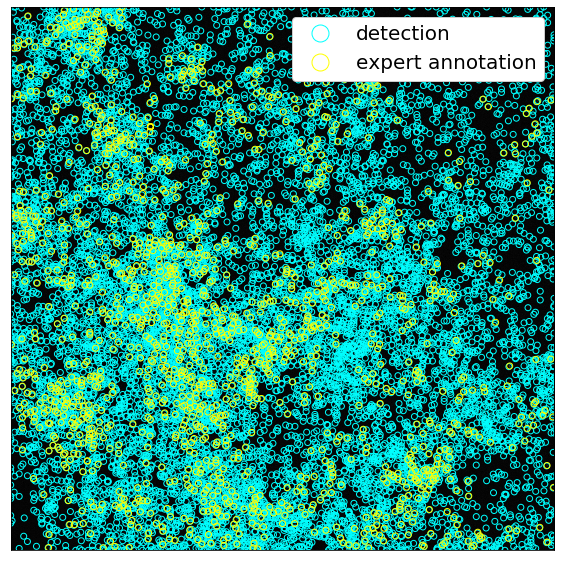

num_spots_sample = 100
0.20984126984126983 0.5854472630173565


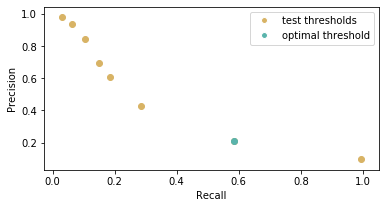

num_blobs = 12600


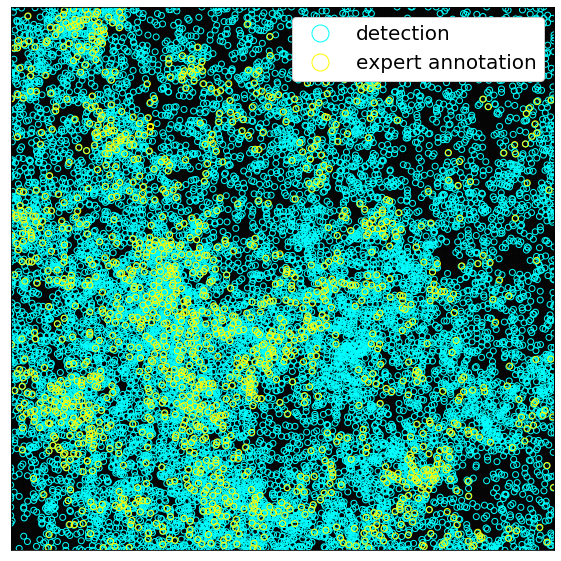

num_spots_sample = 200
0.21578505457598657 0.5687583444592791


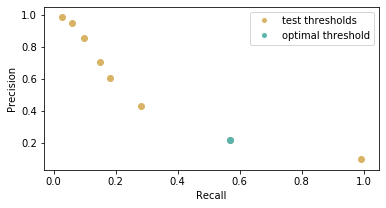

num_blobs = 11910


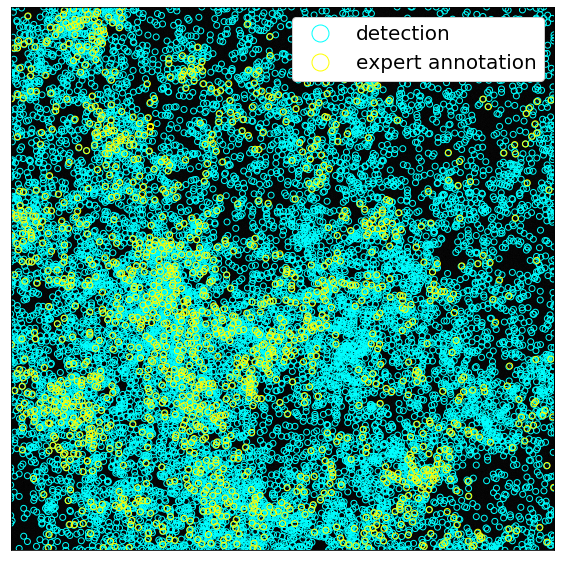

In [7]:
precision_mean_list, precision_std_list, recall_mean_list, recall_std_list = [], [], [], []

for num_spots_sample in num_spots_list:
    
    print('num_spots_sample = %s' % num_spots_sample)

    precision_of_blobs_list, recall_of_blobs_list, best_thresholds_list = [], [], []

    # sample fraction of coords
    idx = np.random.randint(num_spots_total, size=num_spots_sample)
    sample_coords = expert_coords[idx,:]

    # extract params from sample
    sigma_list = param.get_sigma_list(test_img_path, sample_coords, margin)

    if not sigma_list:
        continue

    # calc precision and recall (based on total expert)
    ref_coords = np.asarray(pd.read_csv(expert_path))

    best_threshold, best_recall, best_precision, recall_list, precision_list = param.get_best_threshold(
        ref_coords, test_img_path, min(sigma_list), max(sigma_list), correctness_threshold, test_thresholds)

    print(best_precision, best_recall)
    precision_of_blobs_list.append(best_precision)
    recall_of_blobs_list.append(best_recall)
    best_thresholds_list.append(best_threshold)

    plt.figure(figsize = (6, 3))
    plt.scatter(recall_list, precision_list, c='#d8b365')
#         plt.scatter(recall_list[0], precision_list[0], c='red')
    plt.scatter([best_recall], [best_precision], c='#5ab4ac')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    handle1 = Line2D([0],[0], marker='o', color='w', markerfacecolor='#d8b365', label='test thresholds')
    handle2 = Line2D([0],[0], marker='o', color='w', markerfacecolor='#5ab4ac', label='optimal threshold')
    plt.legend(handles=[handle1, handle2], loc='upper right')

    plt.savefig('./bootstrap_data/BlobDetector_osmFISH_intensities_%s.pdf' % num_spots_sample, transparent=True, bbox_inches="tight")
    plt.show()

    blobs_log = blob_log(
        im, 
        min_sigma=min(sigma_list), 
        max_sigma=max(sigma_list), 
        num_sigma=10, 
        threshold=best_threshold)
    blobs = []
    for r, c, sigma in blobs_log:
        blobs.append([c, r])
    blobs = np.asarray(blobs)

    np.savetxt('./bootstrap_data/%s_blobs_%s.csv' % (test_img_filename, str(num_spots_sample)), blobs)

    print('num_blobs = %s' % len(blobs))

    ####################
    plt.figure(figsize=(10,10))
    plt.scatter(blobs[:,0], blobs[:,1], edgecolor='cyan', facecolor='None')
    plt.imshow(im, cmap='gray')
    ref_coords = np.asarray(pd.read_csv(expert_path))

    plt.scatter(ref_coords[:,0], ref_coords[:,1], edgecolor='yellow', facecolor='None')
    plt.xlim(0, 2048)
    plt.ylim(0, 2048)
    plt.xticks([])
    plt.yticks([])
    
    leg_elem_1 = Line2D([0], [0], marker='o', markersize=17, markeredgecolor='cyan', markerfacecolor='None', color='None', label='detection')
    leg_elem_2 = Line2D([0], [0], marker='o', markersize=17, markeredgecolor='yellow', markerfacecolor='None', color='None', label='expert annotation')
    handle_list = [leg_elem_1, leg_elem_2]
    plt.legend(handles=handle_list, loc='upper right', frameon=1, prop={'size':20}, framealpha=1)

    plt.savefig('./bootstrap_data/BlobDetector_osmFISH_scatter_%s.pdf' % num_spots_sample, transparent=True, bbox_inches="tight")
    plt.show()
    ####################                

    path_a = './bootstrap_data/%s_precisions_%s.csv' % (test_img_filename, str(num_spots_sample))
    path_b = './bootstrap_data/%s_recalls_%s.csv' % (test_img_filename, str(num_spots_sample))
    path_c = './bootstrap_data/%s_thresholds_%s.csv' % (test_img_filename, str(num_spots_sample))
    np.savetxt(path_a, precision_of_blobs_list, delimiter=',')
    np.savetxt(path_b, recall_of_blobs_list, delimiter=',')
    np.savetxt(path_c, best_thresholds_list, delimiter=',')

    precision_mean_list.append(np.mean(precision_of_blobs_list))
    precision_std_list.append(np.std(precision_of_blobs_list))
    recall_mean_list.append(np.mean(recall_of_blobs_list))
    recall_std_list.append(np.std(recall_of_blobs_list))

# save mean and std precision and recall lists
path1 = './bootstrap_data/%s_precision_means.csv' % (test_img_filename)
path2 = './bootstrap_data/%s_precision_stds.csv' % (test_img_filename)
path3 = './bootstrap_data/%s_recall_means.csv' % (test_img_filename)
path4 = './bootstrap_data/%s_recall_stds.csv' % (test_img_filename)
np.savetxt(path1, precision_mean_list, delimiter=",")
np.savetxt(path2, precision_std_list, delimiter=",")
np.savetxt(path3, recall_mean_list, delimiter=",")
np.savetxt(path4, recall_std_list, delimiter=",")

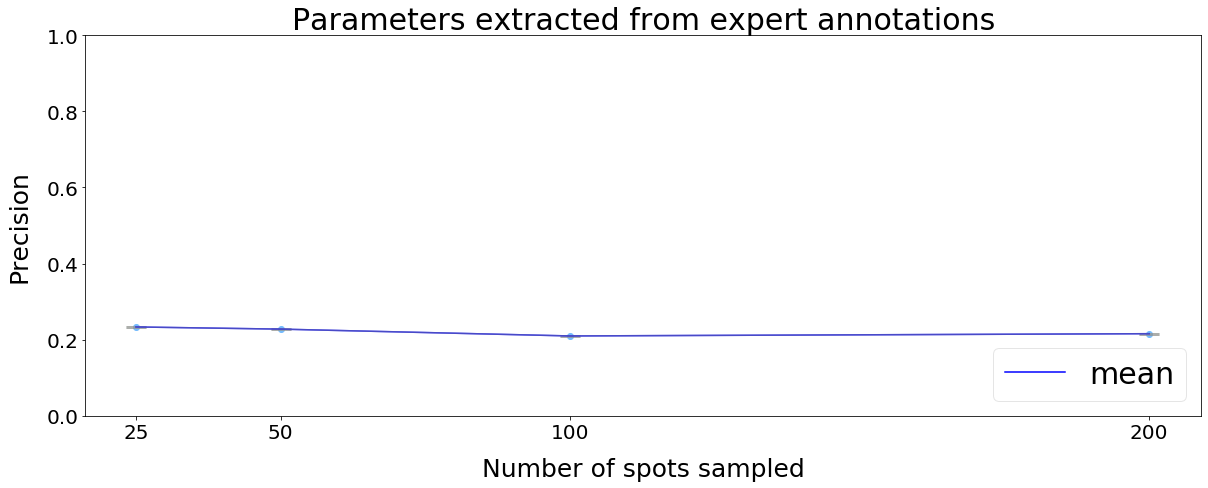

In [8]:
plt.figure(figsize=(20,7))
title = 'Parameters extracted from expert annotations'
plt.title(title, fontsize=30)
precision_means, precision_stds = [], []
for ind, num_spots_sample in enumerate(num_spots_list):

    precisions_path = './bootstrap_data/%s_precisions_%s.csv' % (test_img_filename, num_spots_sample)
    precisions = np.asarray(pd.read_csv(precisions_path, header=None))
    precision_means.append(np.mean(precisions))
    precision_stds.append(np.std(precisions))
    plt.scatter([num_spots_sample]*len(precisions), [precisions], c='xkcd:sky blue')

(_, caps, _) = plt.errorbar(num_spots_list, precision_means, yerr=precision_stds, color='xkcd:gray', capsize=10, elinewidth=3, alpha=0.5)
for cap in caps:
    cap.set_color('xkcd:gray')
    cap.set_markeredgewidth(3)

plt.plot(num_spots_list, precision_means, color='b')
plt.xlabel('Number of spots sampled', fontsize=25, labelpad=15)
plt.ylabel('Precision', fontsize=25, labelpad=15)

leg_elem_1 = Line2D([0], [0], marker='None', color='b', label='mean')
handle_list = [leg_elem_1]
plt.legend(handles=handle_list, loc='lower right', frameon=1, prop={'size':30}, framealpha=0.5)
plt.xticks(num_spots_list, fontsize=20)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)

filename = "%s_bootstrap_precision.pdf" % (test_img_filename)
plt.savefig(filename, transparent=True, bbox_inches="tight")
plt.show()
        

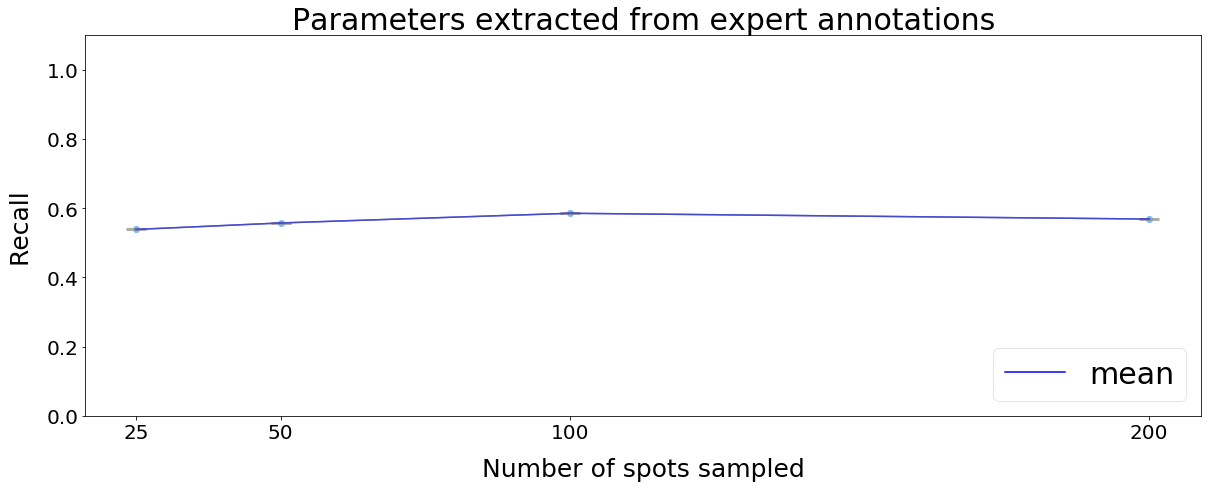

In [9]:
plt.figure(figsize=(20,7))
title = 'Parameters extracted from expert annotations'
plt.title(title, fontsize=30)
recall_means, recall_stds = [], []
for ind, num_spots_sample in enumerate(num_spots_list):

    recalls_path = './bootstrap_data/%s_recalls_%s.csv' % (test_img_filename, num_spots_sample)
    recalls = np.asarray(pd.read_csv(recalls_path, header=None))

    recall_means.append(np.mean(recalls))
    recall_stds.append(np.std(recalls))
    plt.scatter([num_spots_sample]*len(recalls), [recalls], c='xkcd:sky blue')

(_, caps, _) = plt.errorbar(num_spots_list, recall_means, yerr=recall_stds, color='xkcd:gray', capsize=10, elinewidth=3, alpha=0.5)
for cap in caps:
    cap.set_color('xkcd:gray')
    cap.set_markeredgewidth(3)

plt.plot(num_spots_list, recall_means, color='b')
plt.xlabel('Number of spots sampled', fontsize=25, labelpad=15)
plt.ylabel('Recall', fontsize=25, labelpad=15)

leg_elem_1 = Line2D([0], [0], marker='None', color='b', label='mean')
handle_list = [leg_elem_1]
plt.legend(handles=handle_list, loc='lower right', frameon=1, prop={'size':30}, framealpha=0.5)
plt.xticks(num_spots_list, fontsize=20)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=20)
plt.ylim(0, 1.1)

filename = "%s_bootstrap_recall.pdf" % (test_img_filename)
plt.savefig(filename, transparent=True, bbox_inches="tight")
plt.show()
